In [34]:
import sys
sys.path.append('d:/code/pywfn')
from pywfn.base import Mol
from pywfn.reader import LogReader
from pywfn.atomprop import direction
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

## 研究分解键级

In [40]:
frame=pd.DataFrame(data=np.empty(shape=(10,10),dtype=str))
frame.columns=['S','PX','PY','PZ','XX','YY','ZZ','XY','XZ','YZ']
frame.index=['S','PX','PY','PZ','XX','YY','ZZ','XY','XZ','YZ']
frame.loc['S','S']='σ'
frame

,S,PX,PY,PZ,XX,YY,ZZ,XY,XZ,YZ
S,σ,,,,,,,,,
PX,,,,,,,,,,
PY,,,,,,,,,,
PZ,,,,,,,,,,
XX,,,,,,,,,,
YY,,,,,,,,,,
ZZ,,,,,,,,,,
XY,,,,,,,,,,
XZ,,,,,,,,,,
YZ,,,,,,,,,,


In [2]:

path="D:\gfile\pywfn\C6H6.log"
path="D:\gfile\pywfn\CH2=CH2.out"
# path="D:\gfile\pywfn\CH2=CH2_sto3g.out"
# path="D:\gfile\pywfn\Cu=C=C=CH2.out"
mol=Mol(LogReader(path))
# mol.atom(1)._props['normal']=np.array([0.,1.,0.])
# mol.atom(2)._props['normal']=np.array([0.,1.,0.])
# mol.atom(6)._props['normal']=np.array([0.,1.,0.])

In [3]:
def gtf(cords,l,m,n)->np.ndarray:
    x=cords[0,:]
    y=cords[1,:]
    z=cords[2,:]
    r2=x**2+y**2+z**2
    alp=2.0
    facs=[1,1,3]
    fac=facs[l]*facs[m]*facs[n]
    ang=l+m+n
    Nm=(2*alp/np.pi)**(3/4)*np.sqrt((4*alp)**ang/fac)
    val=x**l * y**m * z**n * np.exp(-alp*r2)*Nm
    return val


def decomOrbitals(T:np.ndarray,coefs:np.ndarray,keeps:list):
    if len(coefs)==1:
        return decomOrbitalS(T,coefs,keeps)
    elif len(coefs)==3:
        return decomOrbitalP(T,coefs,keeps)
    elif len(coefs)==6:
        return decomOrbitalD(T,coefs,keeps)
    else:
        return coefs

def decomOrbitalS(T:np.ndarray,coefs:np.ndarray,keeps:list):
    if keeps:
        return coefs
    else:
        return np.array([0.])

# 分解P轨道
def decomOrbitalP(T:np.ndarray,rcoefs:np.ndarray,keeps:list):
    npos=3
    cords=np.random.rand(3,npos) #随机生成6个点
    zs1=np.zeros(shape=(npos,3))
    zs1[:,0]=gtf(cords,1,0,0)
    zs1[:,1]=gtf(cords,0,1,0)
    zs1[:,2]=gtf(cords,0,0,1)

    zs2=np.zeros(shape=(npos,3))
    zs2[:,0]=gtf(T@cords,1,0,0)
    zs2[:,1]=gtf(T@cords,0,1,0)
    zs2[:,2]=gtf(T@cords,0,0,1)

    Mr=np.linalg.inv(zs2)@zs1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs
    for i in range(3):
        if i in keeps:continue
        tcoefs[i]=0.0
    fcoefs=Mi@tcoefs
    return fcoefs

# 分解D轨道
def decomOrbitalD(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int]):
    npos=6
    cords=np.random.rand(3,npos) #随机生成6个点
    zs1=np.zeros(shape=(npos,6))
    zs1[:,0]=gtf(cords,2,0,0)
    zs1[:,1]=gtf(cords,0,2,0)
    zs1[:,2]=gtf(cords,0,0,2)
    zs1[:,3]=gtf(cords,1,1,0)
    zs1[:,4]=gtf(cords,1,0,1)
    zs1[:,5]=gtf(cords,0,1,1)

    zs2=np.zeros(shape=(npos,6))
    zs2[:,0]=gtf(T@cords,2,0,0)
    zs2[:,1]=gtf(T@cords,0,2,0)
    zs2[:,2]=gtf(T@cords,0,0,2)
    zs2[:,3]=gtf(T@cords,1,1,0)
    zs2[:,4]=gtf(T@cords,1,0,1)
    zs2[:,5]=gtf(T@cords,0,1,1)

    Mr=np.linalg.inv(zs2)@zs1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs
    for i in range(6):
        if i in keeps:continue
        tcoefs[i]=0.0
    fcoefs=Mi@tcoefs
    return fcoefs

In [30]:
dirCaler=direction.Calculator(mol) # 方向计算器
# 计算出两个坐标系
atms=[1,4]
atm1,atm2=atms
T1=dirCaler.coordSystem(atm1,atm2) # 两个原子的局部坐标系
T2=dirCaler.coordSystem(atm2,atm1)
Ts=(T1,T2)

CMt=np.zeros_like(mol.CM)
nmat=CMt.shape[0]
keeps={
    0:[0], #s
    1:[0], #px,py,pz
    2:[]   ##xx,yy,zz,xy,xz,yz
}
for o in mol.O_obts:
    coefDict=defaultdict(list) #系数字典
    for i in range(nmat):
        iatm=mol.obtAtms[i]
        ishl=mol.obtShls[i]
        iang=mol.obtAngs[i]
        key=(iatm,ishl,iang)
        if iatm in atms:
            coefDict[key].append(mol.CM[i,o])
        else:
            coefDict[key].append(0)

    for key,val in coefDict.items():
        iatm,ishl,iang=key
        rcoefs=np.array(val)
        if iatm in atms:
            tcoefs=decomOrbitals(Ts[atms.index(iatm)],rcoefs,keeps[iang])
        else:
            tcoefs=rcoefs
        assert len(rcoefs)==len(tcoefs),"长度对不上"
        
        coefDict[key]=tcoefs
    values=list(coefDict.values())
    CMt[:,o]=np.concatenate(values)

-0.70213 0.70213


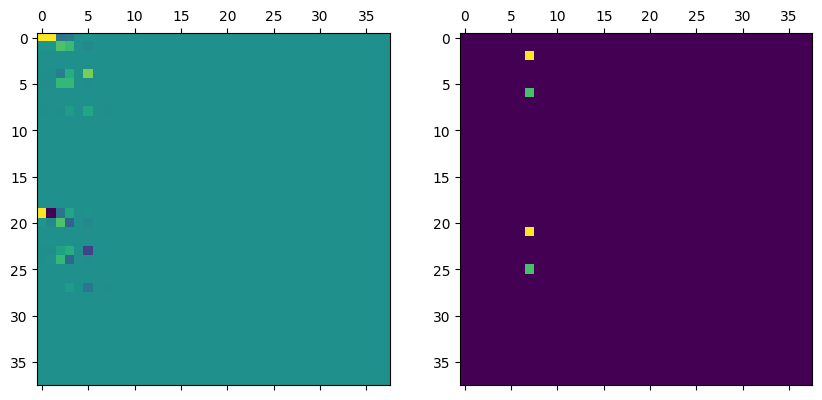

In [31]:
dirs=[dirCaler.normal(atm) for atm in atms]
CMp=mol.projCM(mol.O_obts,atms,dirs,False,False)
print((CMt-CMp).min(),(CMt-CMp).max())
fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].matshow(CMt)
axs[1].matshow(CMp)

In [32]:
from pywfn.bondprop import order
from pywfn.maths import CM2PM
caler=order.Calculator(mol)
PMt=CM2PM(CMt,mol.O_obts,mol.oE)
PMp=CM2PM(CMp,mol.O_obts,mol.oE)
caler.mayer(PMt),caler.mayer(PMp),caler.mayer()

(array([[1.    , 2.    , 0.    ],
        [1.    , 3.    , 0.    ],
        [1.    , 4.    , 1.2803],
        [4.    , 5.    , 0.    ],
        [4.    , 6.    , 0.    ]]),
 array([[1.    , 2.    , 0.    ],
        [1.    , 3.    , 0.    ],
        [1.    , 4.    , 0.9673],
        [4.    , 5.    , 0.    ],
        [4.    , 6.    , 0.    ]]),
 array([[1.    , 2.    , 0.9571],
        [1.    , 3.    , 0.9571],
        [1.    , 4.    , 1.9939],
        [4.    , 5.    , 0.9571],
        [4.    , 6.    , 0.9571]]))

In [33]:
Ts

(array([[ 0., -0.,  1.],
        [ 0.,  1.,  0.],
        [-1.,  0.,  0.]]),
 array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 1.,  0.,  0.]]))